# Example notebook for topological analysis of networks 

This is an example notebook topological analyses that can be run on (un)weighted networks 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import networkx as nx
import seaborn as sns
import scipy.sparse as sp
from connalysis.network import topology

## Unweighted networks 

We will run all our analyses on a small sparse matrix which we load below together with the properties of its 
neurons.

In [2]:
# Load example data (adjacency matrix & neuron properties table)
adj_file = './adj_r0c10.npz'
nrn_file = './nodes_r0c10.h5'
A = sp.load_npz(adj_file)
nrn_table = pd.read_hdf(nrn_file)
print(f'INFO: Loaded connectivity and properties of {nrn_table.shape[0]} neurons')
display(nrn_table)

INFO: Loaded connectivity and properties of 6719 neurons


gid            x            y            z   
circuit subtarget                                                   
Bio_M   R0;C10         455  5349.881407 -2189.938376 -5461.554050  \
        R0;C10         805  5435.330946 -2085.202960 -5411.225766   
        R0;C10        3930  5422.509430 -2121.012844 -5511.005647   
        R0;C10        4303  5441.431546 -1996.386178 -5491.911368   
        R0;C10        5384  5499.207748 -2019.563479 -5524.047901   
...                    ...          ...          ...          ...   
        R0;C10     4232821  4970.456268 -1674.815498 -5508.816697   
        R0;C10     4233489  4910.327651 -1906.233362 -5480.629321   
        R0;C10     4233767  4999.474608 -1794.127000 -5529.009608   
        R0;C10     4233833  4853.452731 -1820.957586 -5495.073773   
        R0;C10     4234008  4714.013589 -1722.643127 -5437.514361   

                  synapse_class  layer   mtype  depth  
circuit subtarget                                      
Bio_M   R0;C10              INH      1  L1_DAC   68.0  
        R0;C10              INH      1  L1_DAC  110.0  
        R0;C10              INH      1  L1_DAC   36.0  
        R0;C10              INH      1  L1_DAC   68.0  
        R0;C10              INH      1  L1_DAC   36.0  
...                         ...    ...     ...    ...  
        R0;C10              INH      5   L5_BP  661.0  
        R0;C10              INH      5   L5_BP  569.0  
        R0;C10              INH      5   L5_BP  524.0  
        R0;C10              INH      5   L5_BP  626.0  
        R0;C10              INH      5   L5_BP  843.0  

[6719 rows x 8 columns]

We also create a small random sparse matrix with zero in the diagonal to demonstrate the more expensive tasks.

In [3]:
N=100 #number of nodes
A_small=sp.random(N,N,density=0.2).astype(bool)
A_small.setdiag(0)
A_small.eliminate_zeros()
print(f'Diagonal entries are all 0: {(np.count_nonzero(A_small.diagonal()!=0))==0}')
print('If false fill diagonal with 0s!!')

Diagonal entries are all 0: True
If false fill diagonal with 0s!!


### Degree distributions

We first observe the degree distributions of the network.

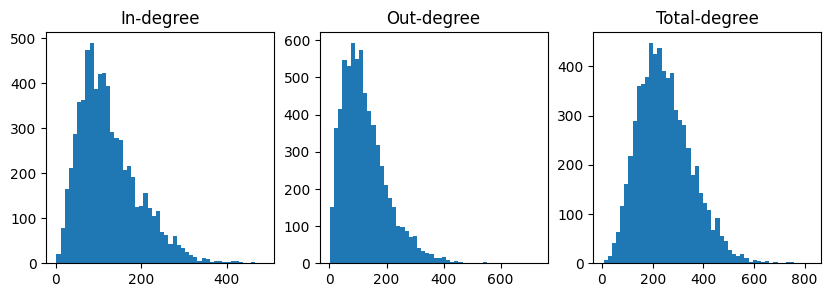

In [4]:
#Getting standard pair-wise degrees
df_degree=topology.node_degree(A,direction=("IN", "OUT"))
fig, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].set_title("In-degree")
axs[0].hist(df_degree["IN"], bins=50)
axs[1].set_title("Out-degree")
axs[1].hist(df_degree["OUT"], bins=50)
axs[2].set_title("Total-degree")
_=axs[2].hist(df_degree["OUT"]+df_degree["IN"], bins=50)


### Simplex counts

We can count the number of directed simplices, reciprocal simplices and undirected simplices.  The counts can always be trunctaed at a maximal dimension max_dim $\geq$ 2.  A directed n-simplex is a set of $n+1$ nodes 
$$(v_0, v_1, \ldots, v_n)$$ 
such that there is a directed edge $v_i\to v_j$ in the network, whenever $i < j$.

Similary, an undirected n-simplex is a set of $n+1$ nodes as above, such that there is an edge between any two pair of nodes.  Equivalently, its an all to all connected subnetwork on $n+1$ nodes in the underlying undirected network. 

Finally, a reciprocal simplex or bisimplex is a set of $n+1$ nodes such that every pair is reciprocally connected.

In all cases we call $n$ the dimension on the simplex.  Below we show examples of 2-dimensional simplices.

<img src="figs/2_simplices.png" />

We can count these with the commands below.  We can also truncate them at a maximum dimension or only count maximal motifs, i.e. motifs that are not contained in higher dimensional ones. 

In [5]:
print("Directed simplex counts")
simplex_type='directed'
print("\nAll")
display(topology.simplex_counts(A,max_simplices=False, threads=1,max_dim=-1,simplex_type=simplex_type))
print("\nMaximal")
display(topology.simplex_counts(A,max_simplices=True,threads=1,max_dim=-1,simplex_type=simplex_type))

print("\n\nUndirected simplex counts truncated at dimension 3")
simplex_type='undirected'
print("Maximal")
display(topology.simplex_counts(A,max_simplices=True, threads=1,max_dim=3,simplex_type=simplex_type))

print("\n\nMaximal reciprocal simplex counts")
simplex_type='reciprocal'
print("All")
display(topology.simplex_counts(A,max_simplices=False, threads=1,max_dim=-1,simplex_type=simplex_type))


Directed simplex counts

All


dim
0       6719
1     836167
2    5146702
3    2691553
4     171035
5       1667
6          1
Name: simplex_count, dtype: int64


Maximal


dim
0          0
1       1486
2    1077150
3    2029003
4     162121
5       1660
6          1
Name: max_simplex_count, dtype: int64



Undirected simplex counts truncated at dimension 3
Maximal


dim
0          0
1       1086
2     826526
3    2248587
Name: max_simplex_count, dtype: int64



Maximal reciprocal simplex counts
All


dim
0     6719
1    12534
2      146
3        1
Name: simplex_count, dtype: int64

We can summarize the results above in a plot

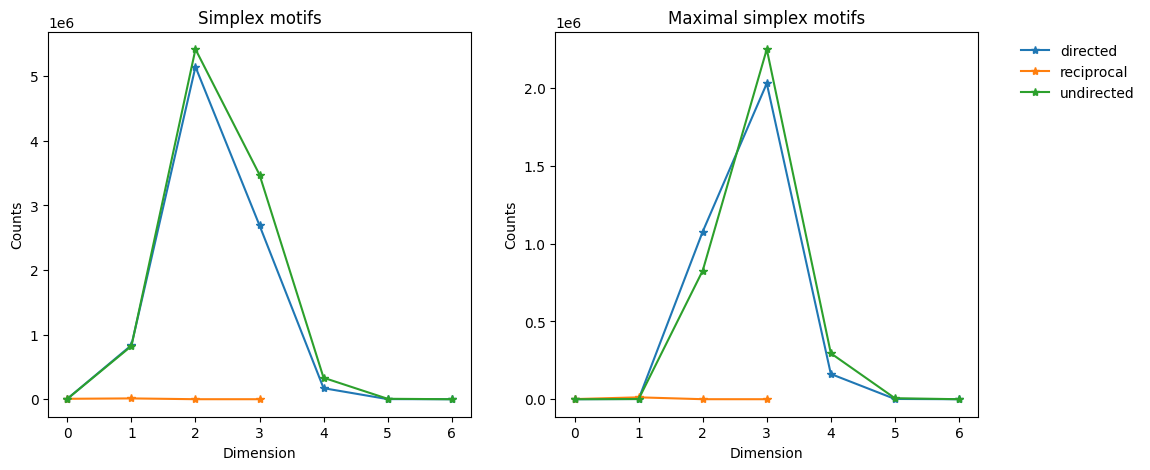

In [6]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
simplex_types=['directed', 'reciprocal', 'undirected']
colors=['C0', 'C1','C2']
axs[0].set_title("Simplex motifs")
axs[1].set_title("Maximal simplex motifs")

for i, simplex_type in enumerate(simplex_types):
    axs[0].plot(topology.simplex_counts(A,max_simplices=False, simplex_type=simplex_type), 
                marker = '*', color=f'C{i}', label=simplex_type)
    axs[1].plot(topology.simplex_counts(A,max_simplices=True, simplex_type=simplex_type), 
                marker = '*', color=f'C{i}', label=simplex_type)
axs[1].legend(frameon=False, bbox_to_anchor=(1.4,1))

for i in [0,1]:
    axs[i].set_xlabel("Dimension")
    axs[i].set_ylabel("Counts")
    axs[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))


We can also get normalized simplex counts.  A number between 0 and 1 that counts the number of directed simplex counts relative to the maximal possible number of simplex counts given the number of undirected simplices in the network.

dim
1    0.507609
2    0.158282
3    0.032260
4    0.004289
5    0.000343
6    0.000006
Name: normalized_simplex_counts, dtype: float64

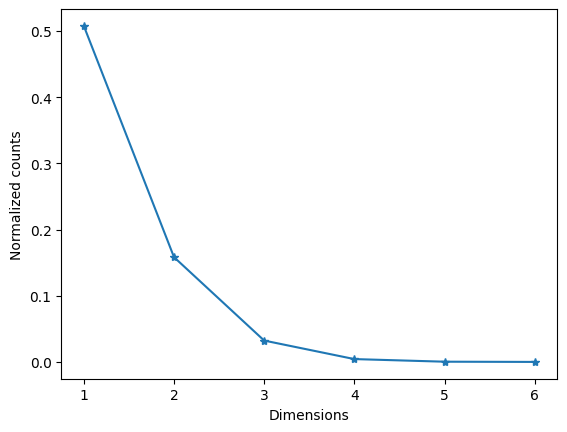

In [7]:
counts=topology.normalized_simplex_counts(A)
display(counts)
plt.plot(counts[counts!=0], marker="*")
plt.xticks(counts.index)
plt.ylabel("Normalized counts")
_=plt.xlabel("Dimensions")

# Generalized in-degree

We can use the notion of a simplex to define generalized degrees i.e. number of $k$-simplices that map to or from a node.  We can choose these simplices to be "directed", "undirected" or "reciprocal".  One can think of these as non-local versions of degree.  Since not only the number of nodes that map to given node matters, but also how those are interconnected to each other.

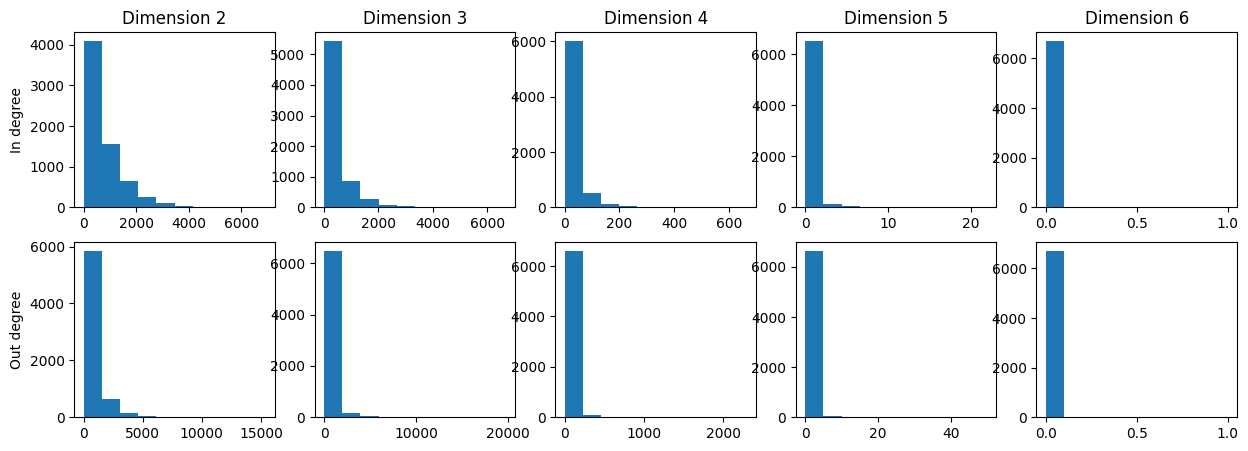

In [8]:
df_degrees=topology.node_k_degree(A)
max_dim=df_degrees.shape[1]//2+1
fig, axs= plt.subplots(2,max_dim-1,figsize=(15,5))
for i in np.arange(2, max_dim+1):
    axs[0,i-2].set_title(f"Dimension {i}")
    axs[0,0].set_ylabel("In degree")
    axs[0,i-2].hist(df_degrees[f'{i}_in_degree'])
    axs[1,0].set_ylabel("Out degree")
    axs[1,i-2].hist(df_degrees[f'{i}_out_degree'])

We can also compute the generalized in degree from a subset of the vertices e.g., a ``source population`` into the remaining vertices

In [9]:
source_pop=np.where(nrn_table['layer'].to_numpy()==2)[0] # Consider layer 2 as the source population
max_simplices=True # Consider only maximal simplices
max_dim=-1 # Consider all dimensions
degs=topology.in_degree_from_pop(A,source_pop) # Generalized in degree from source_pop indexed by the target population
display(degs) 
print("Target population:\n", nrn_table.iloc[degs.index]) # target population 

[2023-08-03 16:06:56,614] INFO: COMPUTE list of simplices by dimension


dim,1,2,3,4,5
0,36,106,68,12,0
1,29,44,2,0,0
2,24,39,7,0,0
3,27,46,5,0,0
4,17,14,0,0,0
...,...,...,...,...,...
6714,6,2,0,0,0
6715,5,1,0,0,0
6716,4,1,0,0,0
6717,2,0,0,0,0


Target population:
                        gid            x            y            z   
circuit subtarget                                                   
Bio_M   R0;C10         455  5349.881407 -2189.938376 -5461.554050  \
        R0;C10         805  5435.330946 -2085.202960 -5411.225766   
        R0;C10        3930  5422.509430 -2121.012844 -5511.005647   
        R0;C10        4303  5441.431546 -1996.386178 -5491.911368   
        R0;C10        5384  5499.207748 -2019.563479 -5524.047901   
...                    ...          ...          ...          ...   
        R0;C10     4232821  4970.456268 -1674.815498 -5508.816697   
        R0;C10     4233489  4910.327651 -1906.233362 -5480.629321   
        R0;C10     4233767  4999.474608 -1794.127000 -5529.009608   
        R0;C10     4233833  4853.452731 -1820.957586 -5495.073773   
        R0;C10     4234008  4714.013589 -1722.643127 -5437.514361   

                  synapse_class  layer   mtype  depth  
circuit subtarget         

# Node participation on simplex motifs as a  centrality metric 

We can compute the number of simplices a node is part of.  This is a form of centrality metric, which is directed, undirected or recurrent depending on the type of simplex used.  We show how to compute these below. 

In [10]:
print('Count node participation in directed simplices (a directed notion of centrality)')
display(topology.node_participation(A, simplex_type='directed'))

print('\nCount node participation in undirected maximal simplices (an undirected notion of centrality)')
display(topology.node_participation(A, max_simplices=True, simplex_type='undirected'))

print('\nCount node participation in reciprocal simplices (a bidirectional notion of centrality)')
display(topology.node_participation(A, simplex_type='reciprocal'))


Count node participation in directed simplices (a directed notion of centrality)


node,0,1,2,3,4,5,6
0,1,282,2377,1366,96,0,0
1,1,183,1046,398,15,0,0
2,1,269,2251,1224,51,0,0
3,1,285,2517,1491,92,0,0
4,1,208,1309,545,41,0,0
...,...,...,...,...,...,...,...
6714,1,86,214,42,1,0,0
6715,1,118,416,88,2,0,0
6716,1,94,225,27,0,0,0
6717,1,63,96,4,0,0,0



Count node participation in undirected maximal simplices (an undirected notion of centrality)


node,0,1,2,3,4,5,6
0,0,0,482,1221,133,5,0
1,0,0,302,516,36,0,0
2,0,0,410,1336,120,0,0
3,0,0,473,1293,170,3,0
4,0,0,427,509,54,0,0
...,...,...,...,...,...,...,...
6714,0,2,128,54,2,0,0
6715,0,0,219,146,8,0,0
6716,0,3,152,39,0,0,0
6717,0,2,97,10,0,0,0



Count node participation in reciprocal simplices (a bidirectional notion of centrality)


node,0,1,2,3
0,1,4,1,0
1,1,2,0,0
2,1,2,0,0
3,1,4,0,0
4,1,0,0,0
...,...,...,...,...
6714,1,0,0,0
6715,1,0,0,0
6716,1,1,0,0
6717,1,0,0,0


# Simplex lists 

We might want to know exactly which nodes are participating in simplices and in which position of the simplex they are.  For this, we can extract simplex lists of a graph.  We can again choose the simplex type and whether we want to consider only maximal motifs or all motifs. 

In [11]:
# This lists can be large so we show it only in our small random example. 
simplex_type='directed' # List directed simplices.  One can change this to 'reciprocal' or 'undirected'
max_simplices=False # List all simplices if True lists only maximal ones 
max_dim=-1 # List all dimensions
nodes=None # List simplices with any source node

display(topology.list_simplices_by_dimension(A_small, max_simplices=max_simplices,
                                             max_dim=max_dim,nodes=nodes,
                                             simplex_type=simplex_type))

[2023-08-03 16:07:18,009] INFO: COMPUTE list of simplices by dimension


dim
0    [[0], [1], [2], [3], [4], [5], [6], [7], [8], ...
1    [[0, 4], [0, 16], [0, 21], [0, 25], [0, 27], [...
2    [[0, 4, 37], [0, 4, 44], [0, 4, 61], [0, 4, 92...
3    [[0, 4, 37, 95], [0, 4, 44, 92], [0, 4, 95, 92...
4    [[0, 16, 77, 67, 25], [0, 25, 37, 65, 77], [0,...
5    [[1, 61, 27, 97, 42, 56], [6, 63, 97, 17, 33, ...
Name: simplices, dtype: object

# Betti counts

One might also be interested in computing the betti numbers of the resulting flag complex.  
Different values of the key  ``simplex_type`` builds different flag complexes.  There are the following options: 
* ``directed`` - Builds the directed flag complex (default)
* ``undirected`` - Builds the undirected flag complex of the underlying undirected graph
* ``reciprocal``- Builds the undirected flag complex of the undirected graph of reciprocal connections

This computation is expensive so we show it only in our small random example

[2023-08-03 16:07:18,108] INFO: Compute betti counts for <class 'scipy.sparse._coo.coo_matrix'>-type adjacency matrix and <class 'NoneType'>-type node properties
[2023-08-03 16:07:18,119] INFO: Run without approximation
[2023-08-03 16:07:18,183] INFO: Compute betti counts for <class 'scipy.sparse._coo.coo_matrix'>-type adjacency matrix and <class 'NoneType'>-type node properties
[2023-08-03 16:07:18,186] INFO: Run without approximation
[2023-08-03 16:07:18,189] INFO: Compute betti counts for <class 'scipy.sparse._coo.coo_matrix'>-type adjacency matrix and <class 'NoneType'>-type node properties
[2023-08-03 16:07:18,193] INFO: Run without approximation


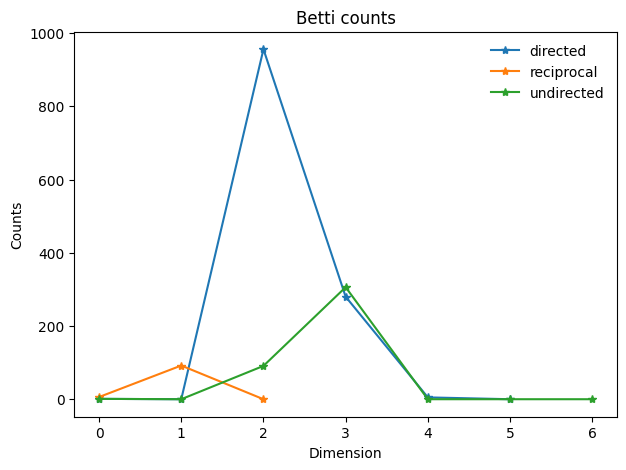

In [12]:
fig, axs = plt.subplots(figsize=(7,5))
simplex_types=['directed', 'reciprocal', 'undirected']
colors=['C0', 'C1','C2']
for i, simplex_type in enumerate(simplex_types):
    axs.plot(topology.betti_counts(A_small, approximation=None, min_dim=0, simplex_type=simplex_type), 
                marker = '*', color=f'C{i}', label=simplex_type)
    
axs.legend(frameon=False)
axs.set_title("Betti counts")
axs.set_xlabel("Dimension")
axs.set_ylabel("Counts")
axs.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

This is a costly non-parallelizable computation.  The rest of the inputs to the function are to restrict the computation to certain dimensions, or to approximate the betti counts

In [13]:
topology.betti_counts(A_small, min_dim=3,approximation = None)

[2023-08-03 16:07:18,456] INFO: Compute betti counts for <class 'scipy.sparse._coo.coo_matrix'>-type adjacency matrix and <class 'NoneType'>-type node properties
[2023-08-03 16:07:18,458] INFO: Run without approximation


dim
3    280
4      5
5      0
Name: betti_count, dtype: int64

In [14]:
topology.betti_counts(A_small, min_dim=1,approximation = None)

[2023-08-03 16:07:18,552] INFO: Compute betti counts for <class 'scipy.sparse._coo.coo_matrix'>-type adjacency matrix and <class 'NoneType'>-type node properties
[2023-08-03 16:07:18,554] INFO: Run without approximation


dim
1      0
2    956
3    280
4      5
5      0
Name: betti_count, dtype: int64

In [15]:
topology.betti_counts(A_small, approximation=[1,1,1], min_dim=0)

[2023-08-03 16:07:18,634] INFO: Compute betti counts for <class 'scipy.sparse._coo.coo_matrix'>-type adjacency matrix and <class 'NoneType'>-type node properties
[2023-08-03 16:07:18,636] INFO: Run betti for dim range 0-2 with approximation 1
[2023-08-03 16:07:18,675] INFO: Run betti for dim range 3-inf with approximation None


dim
0      1
1      0
2    506
3    280
4      5
5      0
Name: betti_count, dtype: int64

In [16]:
topology.betti_counts(A_small, approximation=[100,100,100], min_dim=0)

[2023-08-03 16:07:18,761] INFO: Compute betti counts for <class 'scipy.sparse._coo.coo_matrix'>-type adjacency matrix and <class 'NoneType'>-type node properties
[2023-08-03 16:07:18,763] INFO: Run betti for dim range 0-2 with approximation 100
[2023-08-03 16:07:18,803] INFO: Run betti for dim range 3-inf with approximation None


dim
0      1
1      0
2    841
3    280
4      5
5      0
Name: betti_count, dtype: int64

In [17]:
topology.betti_counts(A_small, approximation=[-1,-1,-1,1,1,1], min_dim=0)

[2023-08-03 16:07:18,889] INFO: Compute betti counts for <class 'scipy.sparse._coo.coo_matrix'>-type adjacency matrix and <class 'NoneType'>-type node properties
[2023-08-03 16:07:18,891] INFO: Run betti for dim range 0-2 with approximation None
[2023-08-03 16:07:18,948] INFO: Run betti for dim range 3-5 with approximation 1
[2023-08-03 16:07:18,991] INFO: Run betti for dim range 6-inf with approximation None


dim
0       1
1       0
2     956
3    2038
4     126
5       0
Name: betti_count, dtype: int64

# Simplicial skeleta

We may want to focus on the subgraph on the edges that participate in (maximal) simplices of a certain dimesion.  We might want to look at all edges in simplices, or just those that belong to the spine of simplices i.e., edges that go from $i$ to $i+1$ in the simplex. 

Warning!  The skeleton of a flag complex is not a flag complex.  That is, if we first restrict to the skeleton graph and then recompute the simplex lists on that dimension, we will NOT recover the original simplex lists. 

We can do this by using the following function and either passing a list of simplices or a graph in which the simplices will first be computed as a dictonary indexed by the dimension to consider.  Since simplex lists can be big we show this is our small random example.

In [18]:
# Using simplex lists directly 
s2=topology.list_simplices_by_dimension(A_small, max_dim=2, max_simplices=True).loc[2:2]
sk2=topology.get_k_skeleta_graph(simplex_list=s2, position="all", N=100)
sk2sp=topology.get_k_skeleta_graph(simplex_list=s2, position="spine", N=100)

print(f"""\nThe original graph has {A_small.sum()} edges. Of these:\n
* {sk2['dimension_2'].sum()} are in maximal 2-simplices and 
* {sk2sp['dimension_2'].sum()} are in the spine of maximal 2-simplices. """)

[2023-08-03 16:07:19,012] INFO: COMPUTE list of max-simplices by dimension

The original graph has 1979 edges. Of these:

* 897 are in maximal 2-simplices and 
* 716 are in the spine of maximal 2-simplices. 


In [19]:
# Passing the graph directly and computing for a single dimension  
topology.get_k_skeleta_graph(A_small,max_simplices=False,dimensions=2,
                             simplex_type='directed',simplex_list=None,N=None, position="all")

[2023-08-03 16:07:19,028] INFO: COMPUTE list of simplices by dimension


{'dimension_2': <100x100 sparse matrix of type '<class 'numpy.bool_'>'
 	with 1979 stored elements in Compressed Sparse Row format>}

In [20]:
# Passing the graph directly and computing for a set of dimensions   
topology.get_k_skeleta_graph(A_small,max_simplices=False,dimensions=[1,4,6],simplex_type='directed',
              simplex_list=None,N=100, position="all")


[2023-08-03 16:07:19,063] INFO: COMPUTE list of simplices by dimension


{'dimension_1': <100x100 sparse matrix of type '<class 'numpy.bool_'>'
 	with 1979 stored elements in Compressed Sparse Row format>,
 'dimension_4': <100x100 sparse matrix of type '<class 'numpy.bool_'>'
 	with 1461 stored elements in Compressed Sparse Row format>}

### Reciprocity within the skeleton

To understan how reciprocal connections inteact with the simplicial skeleton we can see how the percetage of reciprocal connections in the skeleton is changing across dimensions.  We can do this with the following command.

In [21]:
topology.count_rc_edges_skeleta(A_small, position="all", max_dim=3, max_simplices=True)

[2023-08-03 16:07:19,097] INFO: COMPUTE list of max-simplices by dimension
Index([1, 2, 3], dtype='int64', name='dim')


,number_of_edges,number_of_rc_edges,rc/edges_percent
dim,,,
1,0,NaN,NaN
2,897,130,14.492754
3,1950,384,19.692308


In [22]:
topology.count_rc_edges_skeleta(A_small, position="spine", max_simplices=True)

[2023-08-03 16:07:19,134] INFO: COMPUTE list of max-simplices by dimension
Index([1, 2, 3, 4, 5], dtype='int64', name='dim')


,number_of_edges,number_of_rc_edges,rc/edges_percent
dim,,,
1,0,NaN,NaN
2,716,120,16.759777
3,1832,350,19.104803
4,1054,212,20.113852
5,157,30,19.10828
